In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [24]:
# Step 1: Data Loading
data = pd.read_csv('C:/Users/IDEH/Desktop/Alzihmer/Aruba/aruba.20100217-20240201_20240625.181859.txt',
                   sep='\s+', header=None, 
                   names=['Date', 'Time', 'Sensor', 'State'])
data = data.iloc[:20000,:]
# Combine Date and Time columns
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S.%f')

# Drop original Date and Time columns
data = data.drop(['Date', 'Time'], axis=1)

In [25]:
# Step 2: Data Preprocessing
# Encode 'Sensor' column
le_sensor = LabelEncoder()
data['SensorEncoded'] = le_sensor.fit_transform(data['Sensor'])

# Encode 'State' column
le_state = LabelEncoder()
data['StateEncoded'] = le_state.fit_transform(data['State'])

# Function to segment data into 60-second intervals
def segment_data(data, interval='60s'):
    segments = []
    start_time = data['DateTime'].min()
    end_time = data['DateTime'].max()
    
    while start_time < end_time:
        segment = data[(data['DateTime'] >= start_time) & (data['DateTime'] < start_time + pd.Timedelta(interval))]
        if len(segment) > 0:
            # Create a feature vector for this segment
            feature_vector = np.zeros(len(le_sensor.classes_) + len(le_state.classes_))
            for _, row in segment.iterrows():
                feature_vector[row['SensorEncoded']] = 1
                feature_vector[len(le_sensor.classes_) + row['StateEncoded']] = 1
            segments.append(feature_vector)
        start_time += pd.Timedelta(interval)
    
    return np.array(segments)

# Create segments
X = segment_data(data)

# Reshape for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Convert to float32
X = X.astype('float32')

In [26]:
# Step 3: Model Building
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    LSTM(30, activation='relu', return_sequences=False),
    Dense(X.shape[2], activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, X, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
22/22 [==============================] - 7s 56ms/step - loss: 0.2466 - val_loss: 0.2418
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2332 - val_loss: 0.2166
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 0.1875 - val_loss: 0.1560
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.1324 - val_loss: 0.1249
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1159 - val_loss: 0.1138
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1120 - val_loss: 0.1107
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1095 - val_loss: 0.1097
Epoch 8/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1083 - val_loss: 0.1083
Epoch 9/50
22/22 [==============================] - 0s 15ms/step - loss: 0.1073 - val_loss: 0.1074
Epoch 10/50
22/22 [==============================] - 0s 18ms/step - loss: 0.1063 - val_loss: 0.1066
Epoch 11/50

In [27]:
# Step 4: Anomaly Detection
def detect_anomalies(model, X, threshold=0.1):
    predictions = model.predict(X)
    mse = np.mean(np.power(X - predictions, 2), axis=2)
    anomaly_scores = mse.reshape(-1)
    anomalies = anomaly_scores > threshold
    return anomalies, anomaly_scores

anomalies, anomaly_scores = detect_anomalies(model, X)

27/27 [==============================] - 1s 3ms/step


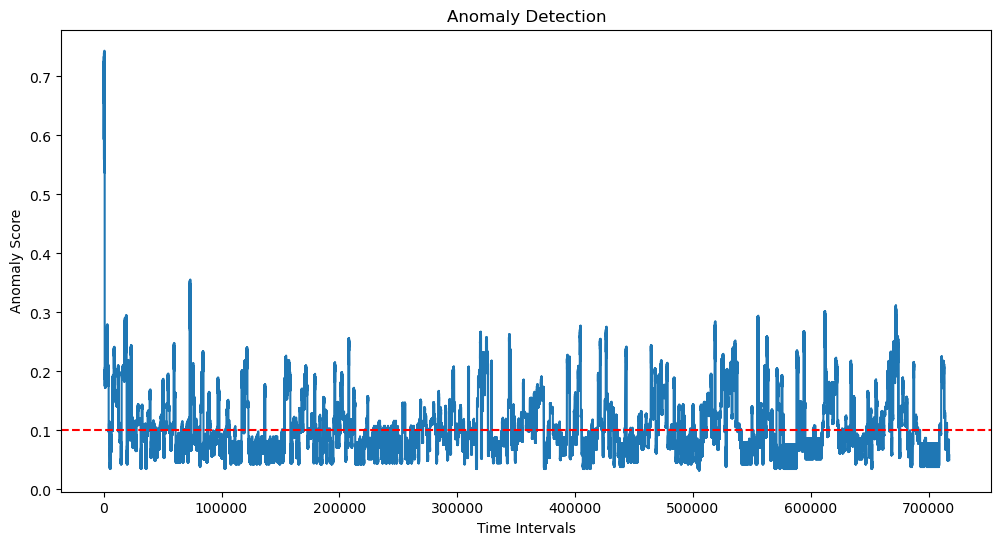

Number of anomalies detected: 279466
Percentage of anomalies: 38.95%


In [28]:
# Plotting anomaly scores
plt.figure(figsize=(12, 6))
plt.plot(anomaly_scores)
plt.axhline(y=0.1, color='r', linestyle='--')
plt.xlabel('Time Intervals')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection')
plt.show()

# Print summary of anomalies
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of anomalies: {np.sum(anomalies) / len(anomalies) * 100:.2f}%")